### Workspace

In [4]:
%matplotlib notebook

from modsim import *

In [5]:
altitude = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 
            8000, 9000, 10000, 15000, 20000, 25000, 30000,
           40000, 50000, 60000, 70000, 80000]
density = [1.225, 1.112, 1.007, .9093, .8194, .7364, .6601,
          .5900, .5258, .4671, .4135, .1948, .08891, .04008,
          .01841, .003996, .001027, .0003097, .00008283, .000001846]

thrust = [90, 204, 306, 388, 457, 523, 591, 664, 722, 774, 836, 887,
          942, 995, 1045, 1098, 1150, 1208, 1236]
current = [1, 3.1, 5.1, 7.1, 9.1, 11.1, 13.1, 15.2, 17.1, 19.1, 21.2,
           23.2, 25.2, 27.3, 29.3, 31.3, 33.3, 35.1, 36.4]

    
dd_da = TimeSeries()
for i in range(20):
    x = altitude[i]
    y = density[i]
    dd_da[x] = y
dd_da = interpolate(dd_da, kind='cubic')

ft_amp = TimeSeries()
count = 0
for i in range(19):
    x = (thrust[i]*4) / 1000
    y = current[i]
    ft_amp[x] = y
ft_amp = interpolate(ft_amp, kind='cubic')

In [6]:
ft_amp(2)

array(10.404471392617655)

In [56]:
condition = Condition(height=90000,
                      thrust_on=200,
                      land = 10,
                      f_thrust=20,
                      mass= .7,
                      length=.1,
                      width=.1,
                      dd_da=dd_da,
                      C_d=1,
                      g=9.8,
                      dt=1)

In [96]:
def make_system(condition):
    unpack(condition)
    
    init = State(height=height, velocity=0)
    
    drag_coef = -C_d*length*width / 2
    
    system = System(init=init,
                    dt=dt,
                    thrust_on=thrust_on, land=land,
                    f_thrust=f_thrust,
                    mass=mass,
                    drag_coef=drag_coef,
                    charge=0,
                    dd_da=dd_da)
    return system

def slope(state, system, dt, count):
    unpack(system)
    height, velocity = state
    
    f_drag = drag_coef * abs(velocity) * velocity * abs(dd_da(height))
    #print(f_drag)
    a_drag = f_drag/mass
    
    if (height < thrust_on):
        f_t= find_thrust_2(height, velocity, g, a_drag, land) * mass
        #print(f_t)
    else:
        f_t=0
    
    system.charge = find_charge(charge, f_t, dt)

    a_thrust = f_t/mass
    a_grav = -g
    a = a_grav + a_thrust + a_drag
    dV = a*dt
    velocity += dV
    
    dH = velocity*dt
    height += dH
         
    return State(height=height, velocity=velocity)

def find_thrust(height, velocity, g, a_drag, land):
    if height < land:
        a_thrust = g + (velocity)**2/(2*height)
    else:
        a_thrust = (g-a_drag) + (abs(velocity)-10)**2/(2*height)
    return a_thrust

def find_thrust_2(height, velocity, g, a_drag, land):
    a_thrust = (g-abs(a_drag)) + (abs(velocity)**2)/(2*height)
    
    if a_thrust < 0:
        a_thrust = 0
    return a_thrust

def find_charge(charge, thrust, dt):
    current = ft_amp(thrust)
    if thrust <= 0:
        current = 0;
    time = dt / 3600
    current_time = current * time * 4
    
    charge += current_time
    #print(charge)
    return charge
    

def run_ode_best(system, slope_func):
    count = 0
    iteration = 0
    unpack(system)
    frame = TimeFrame(columns=init.index)
    
    frame.loc[0] = init
    while(frame.loc[count].velocity < -1 or count < 5):
        frame.loc[count+dt] = slope_func(frame.loc[count], system, dt, count)
        count += dt
        
        iteration += 1
        if iteration >= 50000:
            system.results = frame
            system.count = count
            return
    system.count = count
    system.results = frame
    
def plot_height(system):
    newfig()
    plot(system.results.height, label='y')
        
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
def plot_velocity(system):
    newfig()
    plot(system.results.velocity, label='v')
    
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m)')
    
def plot_atmosphere():
    newfig()
    for i in linrange(1,10000, 500):
        plot(i, dd_da(i), 'g-')
    decorate(xlabel='Altitude(m)',
             ylabel='air density(something)')
def sweep_height():
    newfig()
    condition.set(dt= .1)
    condition.set(height=80000)
    sweep = SweepSeries()
    for x in linrange(500, 2000, 100):
        condition.set(height=x)
        for i in linrange(100, 400, 1):
            print(i)
            condition.set(thrust_on=i)
            system = run_simulation()
            sweep[i] = system.charge
        plot(sweep)
    
    
    decorate(xlabel='Height of Landing Sequence (m)',
             ylabel='Charge Consumed (AH)')
    
def height_at_zero(system):
    t_end = system.count
    #print(t_end)
    t_start = system.count - system.dt
    #print(t_start)
    height = (system.results.height[t_start] + system.results.height[t_end])/2
    return height

def run_simulation():
    system = make_system(condition)
    run_ode_best(system, slope)
    system.final_height = height_at_zero(system)
    
    return system

In [60]:
condition.set(dt= .1)
condition.set(t_end = 20)
condition.set(height = 100000)
condition.set(thrust_on = 200)
run2 = run_simulation()
run2.charge
#run1.results

137.42603498282858

In [10]:
condition.set(dt= .1)
condition.set(t_end = 20)
condition.set(height = 100000)
condition.set(thrust_on = 5000)

run1 = run_simulation()

In [61]:
print(run1.count)
print(run1.dt)
print(run1.final_height)
#print(run1.results.height)

500.0000000000452
0.1
3107.42842018


<IPython.core.display.Javascript object>


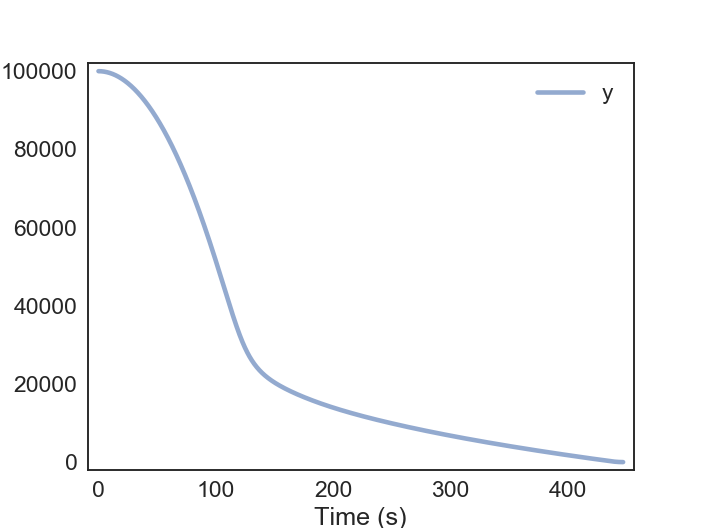

<IPython.core.display.Javascript object>


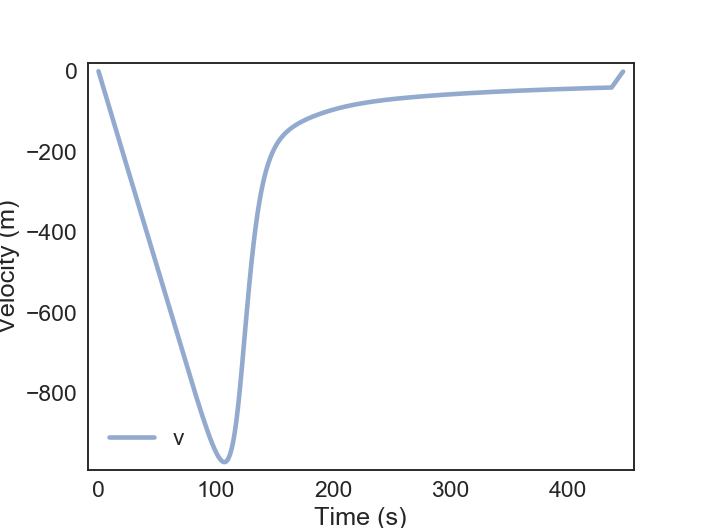

In [62]:
plot_height(run2)
plot_velocity(run2)

In [49]:
run2.results

,height,velocity
0.0,100000.000000,0.000000
0.1,99999.902000,-0.980000
0.2,99999.706000,-1.959999
0.3,99999.412000,-2.939997
0.4,99999.020001,-3.919992
0.5,99998.530003,-4.899984
0.6,99997.942006,-5.879970
0.7,99997.256011,-6.859951
0.8,99996.472018,-7.839925
0.9,99995.590029,-8.819890


<IPython.core.display.Javascript object>


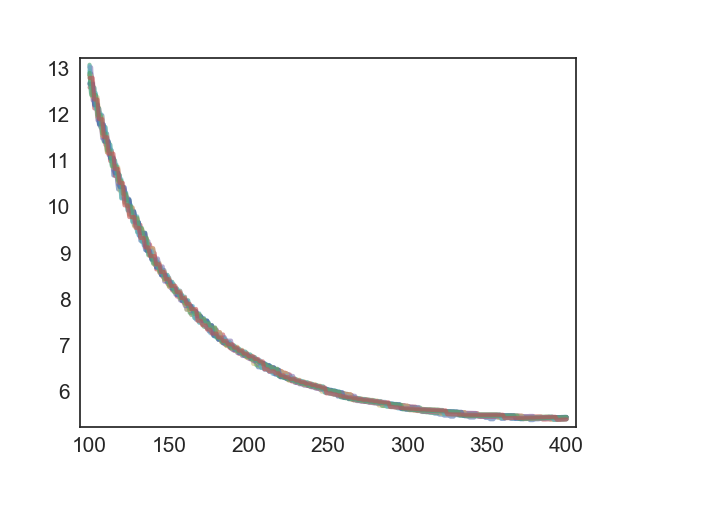

100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.0
186.0
187.0
188.0
189.0
190.0
191.0
192.0
193.0
194.0
195.0
196.0
197.0
198.0
199.0
200.0
201.0
202.0
203.0
204.0
205.0
206.0
207.0
208.0
209.0
210.0
211.0
212.0
213.0
214.0
215.0
216.0
217.0
218.0
219.0
220.0
221.0
222.0
223.0
224.0
225.0
226.0
227.0
228.0
229.0
230.0
231.0
232.0
233.0
234.0
235.0
236.0
237.0
238.0
239.0
240.0
241.0
242.0
243.0
244.0
245.0
246.0
247.0
248.0
249.0
250.0
251.0
252.0
253.0
254.0
255.0
256.0
257.0
258.0
259.0
260.0
261.0
262.0
263.0
264.0
265.0
266.

262.0
263.0
264.0
265.0
266.0
267.0
268.0
269.0
270.0
271.0
272.0
273.0
274.0
275.0
276.0
277.0
278.0
279.0
280.0
281.0
282.0
283.0
284.0
285.0
286.0
287.0
288.0
289.0
290.0
291.0
292.0
293.0
294.0
295.0
296.0
297.0
298.0
299.0
300.0
301.0
302.0
303.0
304.0
305.0
306.0
307.0
308.0
309.0
310.0
311.0
312.0
313.0
314.0
315.0
316.0
317.0
318.0
319.0
320.0
321.0
322.0
323.0
324.0
325.0
326.0
327.0
328.0
329.0
330.0
331.0
332.0
333.0
334.0
335.0
336.0
337.0
338.0
339.0
340.0
341.0
342.0
343.0
344.0
345.0
346.0
347.0
348.0
349.0
350.0
351.0
352.0
353.0
354.0
355.0
356.0
357.0
358.0
359.0
360.0
361.0
362.0
363.0
364.0
365.0
366.0
367.0
368.0
369.0
370.0
371.0
372.0
373.0
374.0
375.0
376.0
377.0
378.0
379.0
380.0
381.0
382.0
383.0
384.0
385.0
386.0
387.0
388.0
389.0
390.0
391.0
392.0
393.0
394.0
395.0
396.0
397.0
398.0
399.0
400.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.

123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
181.0
182.0
183.0
184.0
185.0
186.0
187.0
188.0
189.0
190.0
191.0
192.0
193.0
194.0
195.0
196.0
197.0
198.0
199.0
200.0
201.0
202.0
203.0
204.0
205.0
206.0
207.0
208.0
209.0
210.0
211.0
212.0
213.0
214.0
215.0
216.0
217.0
218.0
219.0
220.0
221.0
222.0
223.0
224.0
225.0
226.0
227.0
228.0
229.0
230.0
231.0
232.0
233.0
234.0
235.0
236.0
237.0
238.0
239.0
240.0
241.0
242.0
243.0
244.0
245.0
246.0
247.0
248.0
249.0
250.0
251.0
252.0
253.0
254.0
255.0
256.0
257.0
258.0
259.0
260.0
261.0
262.0
263.0
264.0
265.0
266.0
267.0
268.0
269.0
270.0
271.0
272.0
273.0
274.0
275.0
276.0
277.0
278.0
279.0
280.0
281.0
282.0
283.0
284.0
285.0
286.0
287.0
288.0
289.

285.0
286.0
287.0
288.0
289.0
290.0
291.0
292.0
293.0
294.0
295.0
296.0
297.0
298.0
299.0
300.0
301.0
302.0
303.0
304.0
305.0
306.0
307.0
308.0
309.0
310.0
311.0
312.0
313.0
314.0
315.0
316.0
317.0
318.0
319.0
320.0
321.0
322.0
323.0
324.0
325.0
326.0
327.0
328.0
329.0
330.0
331.0
332.0
333.0
334.0
335.0
336.0
337.0
338.0
339.0
340.0
341.0
342.0
343.0
344.0
345.0
346.0
347.0
348.0
349.0
350.0
351.0
352.0
353.0
354.0
355.0
356.0
357.0
358.0
359.0
360.0
361.0
362.0
363.0
364.0
365.0
366.0
367.0
368.0
369.0
370.0
371.0
372.0
373.0
374.0
375.0
376.0
377.0
378.0
379.0
380.0
381.0
382.0
383.0
384.0
385.0
386.0
387.0
388.0
389.0
390.0
391.0
392.0
393.0
394.0
395.0
396.0
397.0
398.0
399.0
400.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.

KeyError: 'the label [22.800000000000054] is not in the [index]'

In [97]:
sweep_height()